In [13]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib as plot
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [19]:


# Load data and preprocess
#df = pd.read_csv('20250202-20170908_BTC-USDT_1D_okx_ohlc_M.csv')
#df = pd.read_csv('20250202-20170908_DOGE-USDT_1D_okx_ohlc_M.csv')


# Load data and reverse to chronological order (oldest first)
df = pd.read_csv('20250202-20170908_DOGE-USDT_1D_okx_ohlc_M.csv')#.iloc[::-1].reset_index(drop=True)
df['close'] = pd.to_numeric(df['close'], errors='coerce')

# Compute ATR30 for volatility scaling
df['prev_close'] = df['close'].shift(1)
df['TR'] = np.maximum(
    df['high'] - df['low'],
    np.abs(df['high'] - df['prev_close']),
    np.abs(df['low'] - df['prev_close'])
)
df['ATR30'] = df['TR'].rolling(30).mean()
df['volatility_threshold'] = 0.5 * df['ATR30']

# Label each point based on next 15 days
labels = []
for i in range(len(df) - 15):
    window = df['close'].iloc[i:i+16]  # Current + next 15 days
    current_close = window.iloc[0]
    future_close = window.iloc[-1]
    threshold = df['volatility_threshold'].iloc[i]
    
    # Linear regression slope and p-value
    x = np.arange(len(window))
    slope, _, _, p_value, _ = linregress(x, window)
    
    # Classification
    if (future_close >= current_close * (1 + threshold)) and (slope > 0) and (p_value < 0.05):
        labels.append('upward')
    elif (future_close <= current_close * (1 - threshold)) and (slope < 0) and (p_value < 0.05):
        labels.append('downward')
    else:
        labels.append('stable')

# Pad last 15 rows with NaN (no future data)
labels.extend([np.nan] * 15)
df['state'] = labels

# Output
print(df[['timestamp', 'close', 'state']].dropna())

     timestamp    close   state
0      01:00.4  0.00285  stable
1      00:36.9  0.00302  stable
2      00:13.3  0.00303  stable
3      59:49.8  0.00300  stable
4      59:26.2  0.00300  stable
...        ...      ...     ...
2023   59:53.9  0.32434  stable
2024   59:30.3  0.33644  stable
2025   59:06.8  0.33955  stable
2026   00:54.3  0.32206  stable
2027   00:30.7  0.29470  stable

[2028 rows x 3 columns]


<AxesSubplot:>

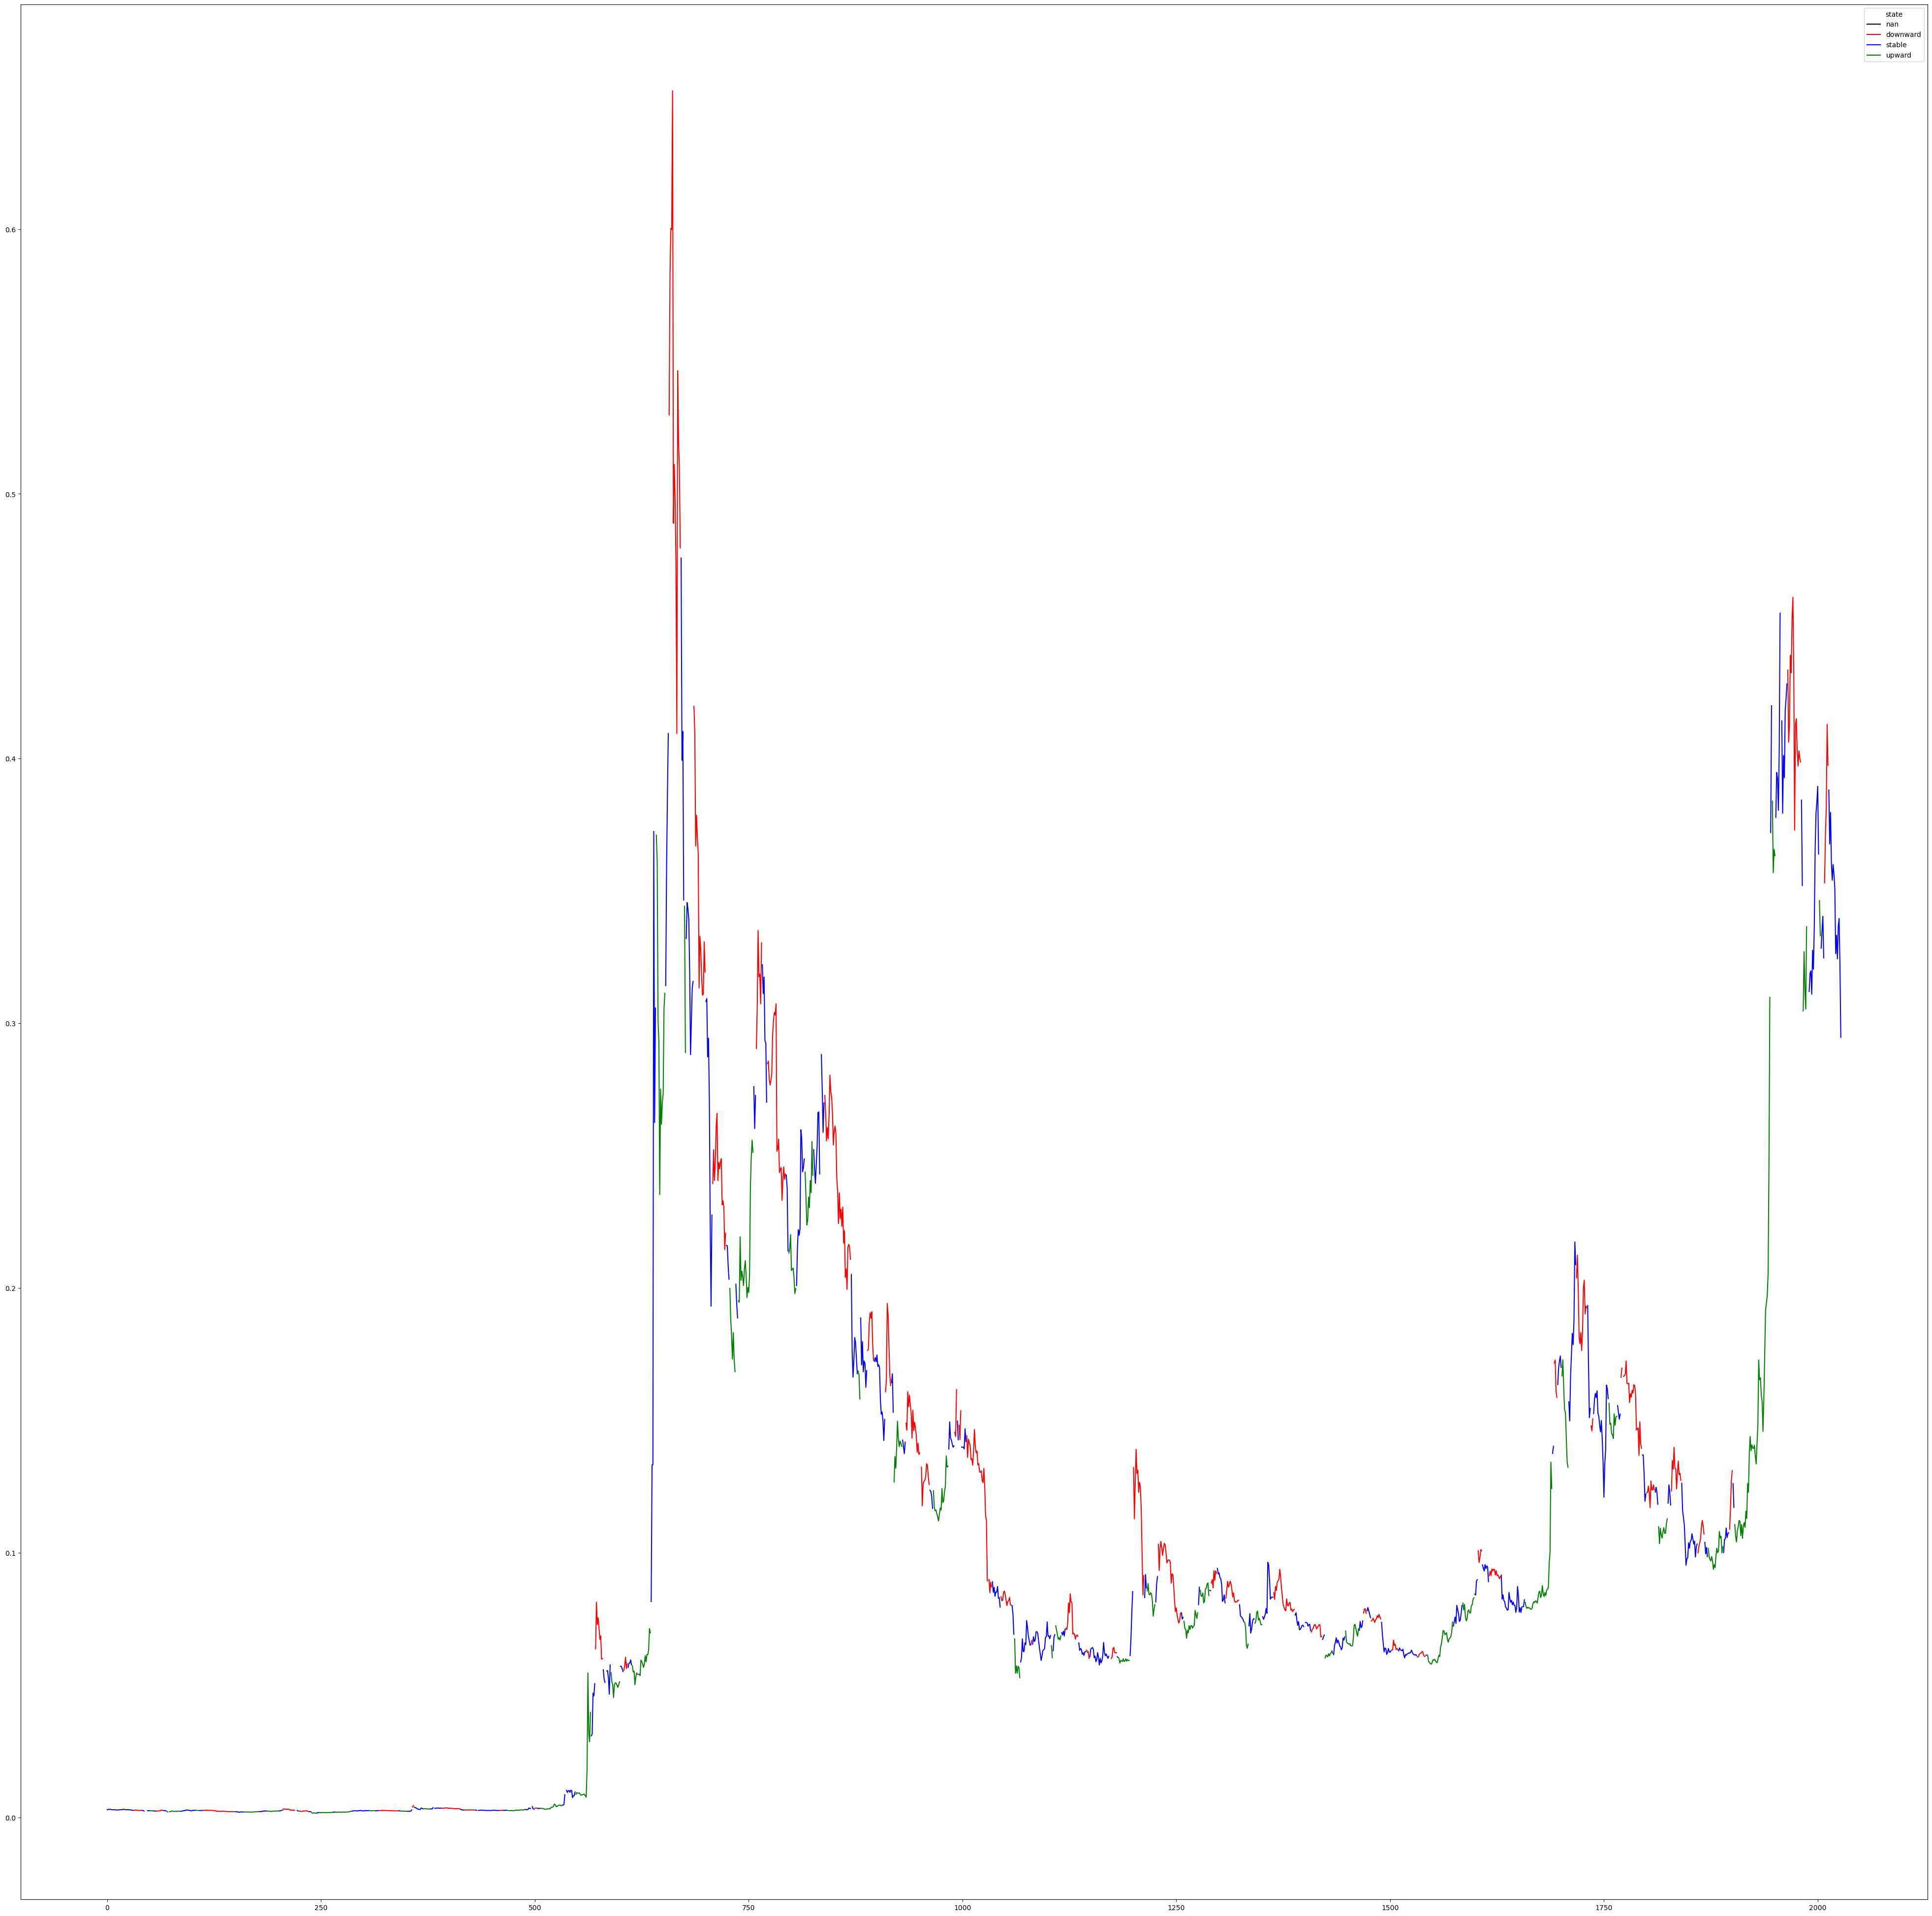

In [20]:


graph_df = df.set_index('state', append=True)['close']
graph_df = graph_df.unstack('state')
colors_map = {'stable': 'b',
              'downward': 'red',
              'upward': 'green',
              '0': 'black',
             }
colors_map[np.nan] = 'black'
#BTC_mm_plot['date'] = BTCUSDT_data['Date']

plot.rcParams['figure.figsize'] = [50, 50]
graph_df.plot(color=colors_map)